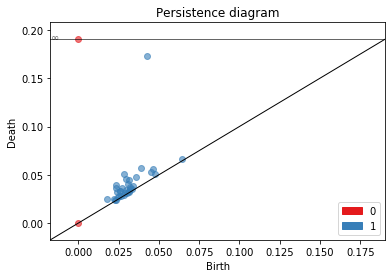

In [2]:
import matplotlib.pyplot as plot
import gudhi

# rips_on_tore3D_1307.pers obtained from write_persistence_diagram method
persistence_file='/home/bazyli/gitworkspace/gitBKrp/pcodebooks/rawdata/exp01_synthetic/pd_gauss_0_1/Circle/11.h5.pc.simba.1.00001_3.persistence'
a=gudhi.plot_persistence_diagram(persistence_file=persistence_file,
    legend=True)
plot.show()


In [3]:
import numpy as np
arr = gudhi.read_persistence_intervals_in_dimension(persistence_file, only_this_dim=1)

In [4]:
from gudhi.representations.preprocessing import BirthPersistenceTransform

In [188]:
arr = np.reshape(arr, (1,-1,2))

In [100]:
transformer = BirthPersistenceTransform()

In [191]:
arr = transformer.transform(arr)

In [203]:
X = np.array(arr)

In [207]:
X = X.reshape((2,-1,2))

In [210]:
X.shape

(2, 17, 2)

In [220]:
ps = RandomPDSampler(3, lambda x: x**2)
ps.transform(X)

array([[0.0427533, 0.1304427],
       [0.0283355, 0.0229157],
       [0.0296474, 0.0163507]])

# Matlab data loading and processing

In [354]:
import numpy as np
import scipy.io
from gudhi.representations.preprocessing import BirthPersistenceTransform, DiagramScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from preprocessing import *
from persistent_bow import *
from visualization import *

In [355]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

In [356]:
data.shape # Here are 50 diagrams (rows), 7 types(cols) = 350 diagrams

(50, 7)

In [357]:
data[0][1].shape # each diagram has n rows and 2 colums # here we get first diagram from type "1"

(23, 2)

In [358]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [376]:
pipeline = Pipeline([
    ("name1", BirthPersistenceTransform()),
    ("name2", DiagramScaler()),
    ("name3", RandomPDSampler(2500)),
    #("name4", PersistentBow(5))
])

bow = PersistentBow(7)

In [377]:
transformed = pipeline.fit_transform(X_train)
bow.fit(transformed)

PersistentBow(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
              n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
              random_state=None, tol=0.0001, verbose=0)

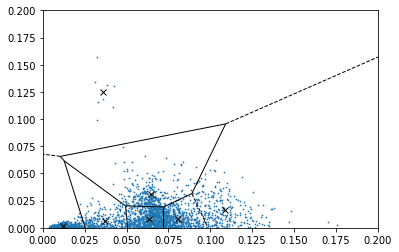

In [378]:
plot_voronoi(bow, plot_range=(0.2, 0.2))
plt.scatter(transformed[0][:, 0], transformed[0][:, 1], s=0.5)

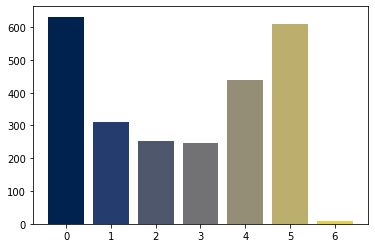

In [379]:
plot_persistence_bow(transformed[0], bow)

### Wstepne proby uczenia

In [371]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [410]:
# Generowanie wektorow persistence bag of words
# do dodania do pipelineu ? nie wiadomo jeszcze jak ?

def generate_vectors(diagrams, lr_bow):
    train_M = []
    for pd in diagrams:
        pred_clusters = lr_bow.predict([pd])[0]
        bins = list(range(lr_bow.n_clusters))
        histogram = np.bincount(pred_clusters, minlength=lr_bow.n_clusters)
        train_M.append(histogram)

    return np.array(train_M)

In [411]:
M_train = generate_vectors(X_train, bow)
M_test = generate_vectors(X_test, bow)

In [412]:
M_train.shape # ok mamy wektory a ich labelki to y_train

(280, 7)

In [422]:
svc = SVC(kernel='precomputed')

# Nie wiem czy te jadra tak to jest poprawnie
# Nie udalo mi sie wywnioskowac z artykulu jak ma funkcja k wygladac
kernel_train = np.dot(M_train, M_train.T)  # precomputed linear kernel

svc.fit(kernel_train, y_train)

kernel_test = np.dot(M_test, M_train.T)
y_pred = svc.predict(kernel_test)

accuracy_score(y_pred,y_test)

0.9571428571428572